In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import logging

In [2]:
import torch
from torch.distributions import constraints
from torch import nn

In [3]:
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import pyro.distributions as dist

from pyro.nn import PyroModule
from pyro.nn import PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal,AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

# pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.8.4')

In [4]:
logging.basicConfig(format='%(message)s', level=logging.INFO)

### data setup

In [5]:
real_estate = pd.read_excel("./Real estate valuation data set.xlsx",index_col=0)

x_cols = [x for x in real_estate.columns if "Y house" not in x]
print(x_cols)

X = real_estate[x_cols]
y = np.log(real_estate["Y house price of unit area"])

['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']


In [6]:
x_data = torch.tensor(X.values, dtype=torch.float)
y_data = torch.tensor(y.values, dtype=torch.float)

### Write the model

In [7]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(-0.001, 0.25).expand([out_features, in_features]\
                                                                         ).to_event(out_features))
        self.linear.bias = PyroSample(dist.Normal(4.0, 0.25).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.0))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [8]:
br_model = BayesianRegression(X.shape[1], 1)

#### Sample with SVI Multivariate Diagonal

In [9]:
num_iters = 10000
guide = AutoDiagonalNormal(br_model)

adam = pyro.optim.Adam({"lr": 0.08})
svi = SVI(br_model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
# num_iters = 5000 if not smoke_test else 2
for i in range(num_iters):
    elbo = svi.step(x_data,y_data)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 26407163.28546512
Elbo loss: 83732.16653478146
Elbo loss: 34501.52164661884
Elbo loss: 6639.948271036148
Elbo loss: 71458.34105873108
Elbo loss: 50281.50575232506
Elbo loss: 3344.7380958795547
Elbo loss: 16362.459335803986
Elbo loss: 8173.0844810009
Elbo loss: 41292.775770783424
Elbo loss: 6297.695990562439
Elbo loss: 36011.33441233635
Elbo loss: 5601.082988858223
Elbo loss: 48688.357726216316
Elbo loss: 24930.007504940033
Elbo loss: 3462.1335653066635
Elbo loss: 40879.727977752686
Elbo loss: 12066.521195173264
Elbo loss: 5855.493880271912
Elbo loss: 4271.852077126503


In [10]:
from pyro.infer import Predictive


num_samples = 250
predictive = Predictive(br_model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(v.shape[0],v.shape[-1]).detach().cpu().numpy()
               for k, v in predictive(x_data).items()
               if k != "obs"}

In [11]:
svi_samples.keys()

dict_keys(['sigma', 'linear.weight', 'linear.bias'])

In [12]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

pred_summary = summary(svi_samples)

In [14]:
param_diagonal = pd.DataFrame()
for key, val_torch in svi_samples.items():
    val_np = val_torch
    if "linear" in key or "sigma" in key:
        param_diagonal[[f"{key}_{i}" for i in range(val_np.shape[1])]] = val_np

In [13]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.990393  0.000464  0.989624  0.990116  0.990423  0.990696  0.991134 

Site: linear.weight
       mean       std        5%       25%       50%       75%       95%
0 -0.002964  0.000237 -0.003325 -0.003124 -0.002977 -0.002816 -0.002589
1 -0.004511  0.004265 -0.011269 -0.007218 -0.004875 -0.001293  0.002196
2  0.002115  0.000362  0.001455  0.001915  0.002104  0.002318  0.002731
3  0.036455  0.012825  0.016793  0.027381  0.036653  0.044000  0.056680
4  0.070180  0.003240  0.065227  0.068121  0.070083  0.072229  0.075818
5  0.086372  0.001185  0.084487  0.085547  0.086384  0.087246  0.088282 

Site: linear.bias
       mean       std        5%       25%       50%       75%       95%
0  4.011437  0.035446  3.957321  3.988761  4.010196  4.035036  4.069526 



### SVI MultivariateNormal Guide

In [15]:
guide = AutoMultivariateNormal(br_model, init_loc_fn=init_to_mean)

num_iters = 10000
svi = SVI(br_model, 
          guide, 
          optim.Adam({"lr": 0.1}), 
          loss=Trace_ELBO())

pyro.clear_param_store()
for i in range(num_iters):
    elbo = svi.step(x_data,y_data)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 67135221.84347153
Elbo loss: 14231.603753566742
Elbo loss: 13196.04224562645
Elbo loss: 23293.818566560745
Elbo loss: 37248.93608856201
Elbo loss: 1915.301302075386
Elbo loss: 61848.46991443634
Elbo loss: 1313.671841621399
Elbo loss: 4095.9028675556183
Elbo loss: 168987.70394921303
Elbo loss: 2281.3248369693756
Elbo loss: 1112.9937517642975
Elbo loss: 25016.16336297989
Elbo loss: 3523.0599913597107
Elbo loss: 544.5957942008972
Elbo loss: 2330.2737548947334
Elbo loss: 6108.640741288662
Elbo loss: 6662.051861524582
Elbo loss: 724.6317608356476
Elbo loss: 638.0016359090805


In [16]:
predictive = Predictive(br_model, guide=guide, num_samples=num_samples)
svi_mvn_samples = {k: v.reshape(v.shape[0],v.shape[-1]).detach().cpu().numpy()
               for k, v in predictive(x_data).items()
               if k != "obs"}

In [17]:
param_mvn = pd.DataFrame()
for key, val_torch in svi_mvn_samples.items():
    val_np = val_torch
    if "linear" in key or "sigma" in key:
        param_mvn[[f"{key}_{i}" for i in range(val_np.shape[1])]] = val_np

In [18]:
import seaborn as sns

In [ ]:
# n_vars = X.shape[1]+2
# fig, axs = plt.subplots(nrows=2, ncols=int(n_vars/2)+1, figsize=(12, 5*int(n_vars/2)+1))
# fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)

# for i, ax in enumerate(axs.reshape(-1)):
#     if i<len(param_mvn.columns):
#         site = param_mvn.columns[i]
#         sns.distplot(param_mvn[site], ax=ax, label="SVI (Multivariate Normal)")
#         sns.distplot(param_diagonal[site], ax=ax, label="SVI (Diagonal)")
#         ax.set_title(site)
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right');

In [ ]:
# svi_samples.keys()

### HMC

In [19]:
from pyro.infer import MCMC, NUTS


nuts_kernel = NUTS(br_model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(x_data,y_data)

Sample: 100%|████████████████████████████████████████| 1200/1200 [18:33,  1.08it/s, step size=1.04e-03, acc. prob=0.285]                                                       


In [21]:
hmc_samples = {}
for k, v in mcmc.get_samples().items():
    if "linear" in k:
        hmc_samples[k] = v.reshape(v.shape[0],v.shape[-1]).detach().cpu().numpy()
    else:
        hmc_samples[k] = v.detach().cpu().numpy()

In [22]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: linear.bias
       mean       std        5%      25%     50%       75%       95%
0  1.137373  0.673791 -0.175677  0.51134  1.3922  1.723343  1.724151 

Site: linear.weight
       mean       std        5%       25%       50%       75%       95%
0 -0.014014  0.003859 -0.021144 -0.014645 -0.014524 -0.011124 -0.008039
1 -0.006533  0.000964 -0.008027 -0.007113 -0.006645 -0.005868 -0.004953
2 -0.000186  0.000012 -0.000205 -0.000194 -0.000186 -0.000177 -0.000166
3  0.032339  0.005170  0.024670  0.028398  0.032547  0.035572  0.040587
4 -0.140045  0.079493 -0.220317 -0.219897 -0.123076 -0.061705 -0.032624
5  0.282424  0.069827  0.169274  0.220490  0.302344  0.303563  0.396843 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.249028  0.017096  0.242496  0.242651  0.244519  0.249578  0.260389 



In [23]:
param_hmc = pd.DataFrame()
for key, val_torch in hmc_samples.items():
    val_np = val_torch
    if "linear" in key:
        param_hmc[[f"{key}_{i}" for i in range(val_np.shape[1])]] = val_np
    if "sigma" in key:
        param_hmc["sigma_0"] = val_np

### Posterior plot

/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_37742/294166243.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(param_mvn[site], ax=ax, label="SVI (Multivariate Normal)")
/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_37742/294166243.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_37742/294166243.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(param_diagonal[site], ax=ax, label="SVI (Diagonal)")
/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_37742/294166243.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  s

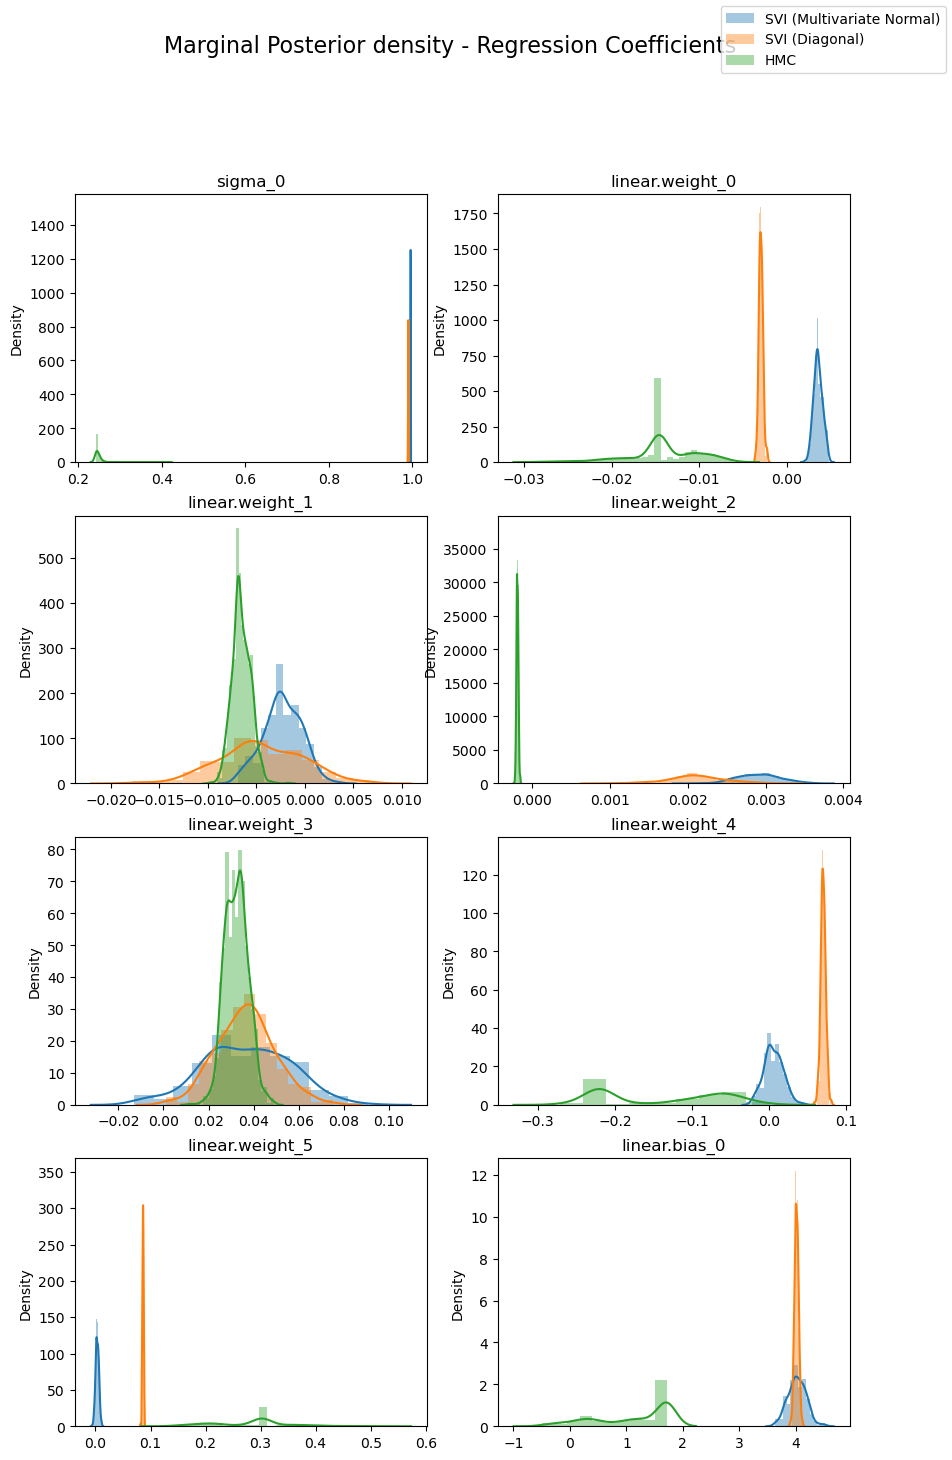

In [26]:
n_vars = X.shape[1]+2
fig, axs = plt.subplots(nrows=int(n_vars/2), ncols=2, figsize=(10,4*int(n_vars/2)))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)

for i, ax in enumerate(axs.reshape(-1)):
    if i<len(param_mvn.columns):
        site = param_mvn.columns[i]
        sns.distplot(param_mvn[site], ax=ax, label="SVI (Multivariate Normal)")
        sns.distplot(param_diagonal[site], ax=ax, label="SVI (Diagonal)")
        sns.distplot(param_hmc[site], ax=ax, label="HMC")
        ax.set_xlabel("")
        ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

### Diagonal vs MVN

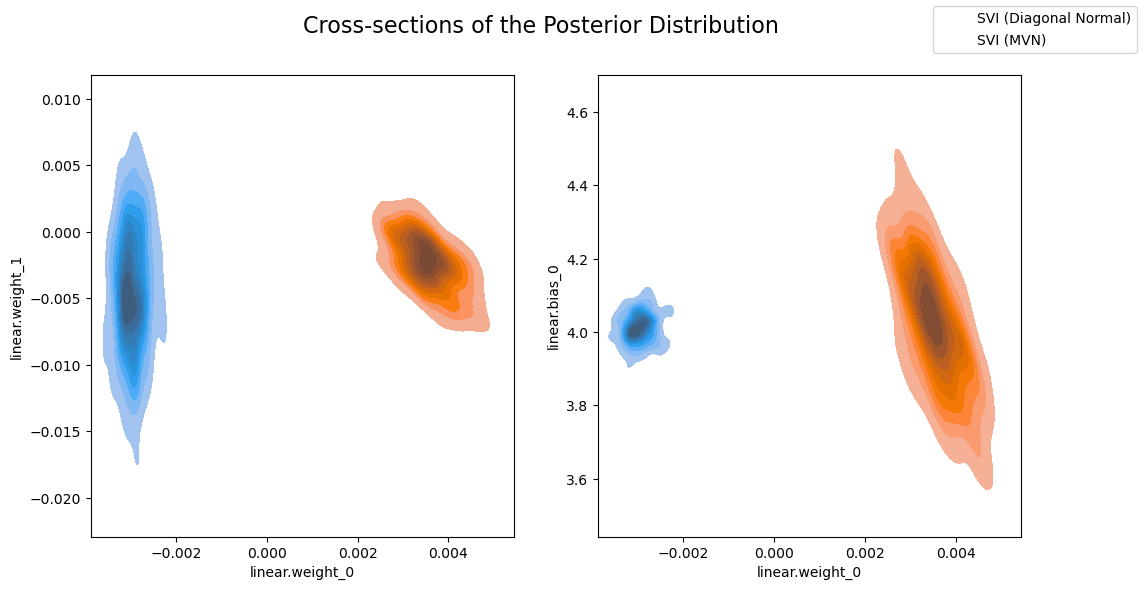

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)

sns.kdeplot(x=param_diagonal["linear.weight_0"], y=param_diagonal["linear.weight_1"], ax=axs[0],\
            label="SVI (Diagonal Normal)", fill=True)
sns.kdeplot(x=param_mvn["linear.weight_0"], y=param_mvn["linear.weight_1"], ax=axs[0],\
            label="SVI (MVN)", fill=True)
# sns.kdeplot(x=param_hmc["linear.weight_0"], y=param_hmc["linear.weight_1"], ax=axs[0],\
#             label="HMC", fill=True)
axs[0].set(xlabel="linear.weight_0", ylabel="linear.weight_1")


a=sns.kdeplot(x=param_diagonal["linear.weight_0"], y=param_diagonal["linear.bias_0"], ax=axs[1],\
            label="SVI (Diagonal Normal)", fill=True)
b=sns.kdeplot(x=param_mvn["linear.weight_0"], y=param_mvn["linear.bias_0"], ax=axs[1],\
            label="SVI (MVN)", fill=True)
# c=sns.kdeplot(x=param_hmc["linear.weight_0"], y=param_hmc["linear.bias_0"], ax=axs[1],\
#             label="HMC", fill=True)
axs[1].set(xlabel="linear.weight_0", ylabel="linear.bias_0")
# fig.legend([a,b,c],labels=['SVI (Diagonal Normal)','SVI (MVN)','HMC'])
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');